## Regress out cell counts from all features on full dataset

In [1]:
import sys
sys.path.append("../scripts")

import numpy as np
import pandas as pd

from load import load_config
from preprocess import preprocess_profiles
from plot_utils import plot_unique_value_hist
from correct_position_effect import (
    subtract_well_mean,
    regress_out_cell_counts,
)

import seaborn as sns
from matplotlib import pyplot as plt

#### Load configs

In [2]:
cc_config = load_config("../configs/correction/regress_cell_count.yaml")
print(cc_config)
preprocess_config = load_config("../configs/preprocess")
print(preprocess_config)

{'cc_col': 'Cells_Count', 'min_unique': 100}
{'normalize_group': 'Metadata_Plate', 'normalize_kwargs': {'method': 'mad_robustize', 'mad_robustize_epsilon': 0.0, 'image_features': True}, 'feature_select_whitelist': ['Cells_Count'], 'feature_select_kwargs': {'operation': ['variance_threshold', 'correlation_threshold', 'drop_na_columns', 'blocklist'], 'unique_cut': 0.01, 'image_features': True}}


#### Load profiles

In [3]:
ann_profiles = pd.read_parquet("../1.load/output/raw_filtered_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,71.441002,66.777000,67.111000,66.614998,66.950996,67.466003,69.115997,67.341003,69.023003,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,76.763000,72.568001,73.039001,72.873001,73.301003,73.550003,75.428001,73.696999,75.563004,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,91.638000,86.575996,87.012001,86.803001,87.361000,87.459999,89.482002,87.972000,90.033997,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,47.766998,45.113998,45.214001,45.137001,45.473999,45.556000,46.622002,45.544998,46.728001,2021_08_30_Batch13


In [4]:
ann_profiles.filter(regex="^(?!Metadata_)").isnull().any().any()

False

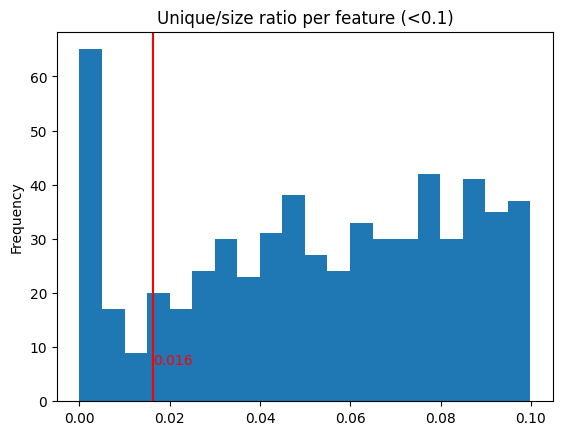

In [5]:
plot_unique_value_hist(ann_profiles, unique_ratio_cutoff = 0.1, features="Cells_Count")

#### Explore correlations with cell counts

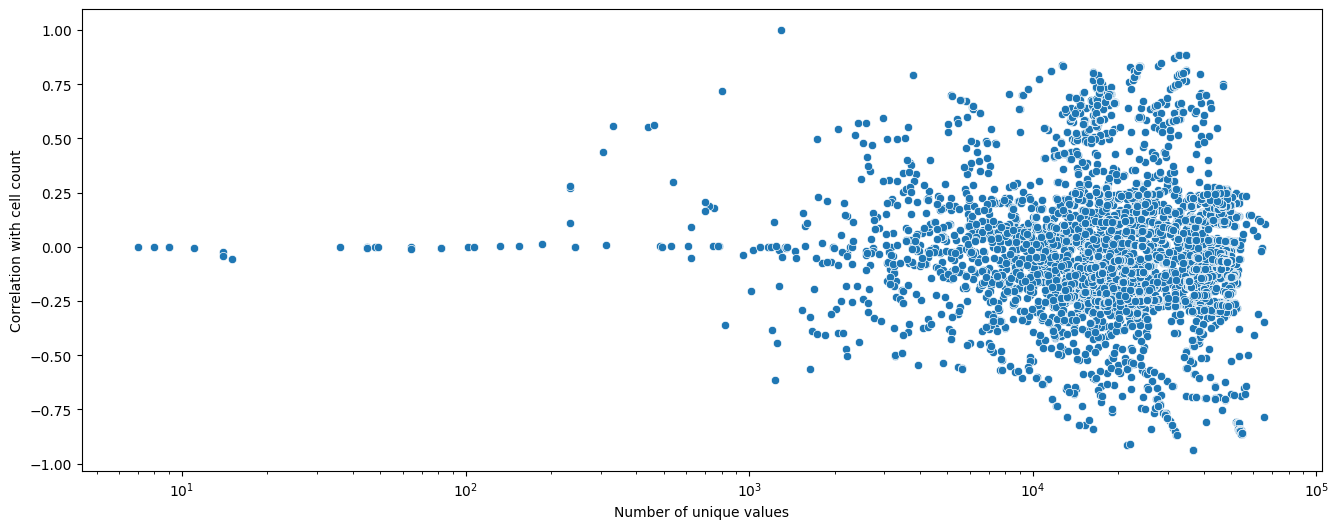

In [6]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    # hue=ann_profiles.filter(regex="^(?!Metadata_)")
    # .corrwith(ann_profiles["Cells_Count"])
    # .abs()
    # > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")

# plt.axhline(y=corr_cutoff, color="red", linestyle="--")
# plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### List low unique ratio features that are correlated with cell count

No features that have nigh correlations and less than 1000 unique values

In [7]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_profiles[
        feature
    ].nunique() < 1000:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Image_Threshold_SumOfEntropies_CellsIncludingEdges: 0.719204705093529
Nuclei_Correlation_Manders_AGP_RNA: 0.5543123213473639
Nuclei_Correlation_Manders_DNA_RNA: 0.4355270570234875
Nuclei_Correlation_Manders_ER_RNA: 0.5561504156643421
Nuclei_Correlation_Manders_Mito_RNA: 0.5608293614930626


#### Regress out cell counts only from features that have >100 unique values

In [8]:
ann_profiles = regress_out_cell_counts(ann_profiles, **cc_config)
ann_profiles

  0%|          | 0/4710 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [9]:
ann_profiles.to_parquet("output/profiles_cc_adjusted.parquet")

#### Check if cell count has correlation above 0.5 with any feature

In [10]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if np.abs(feature_corr) > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cells_Count: 1.0


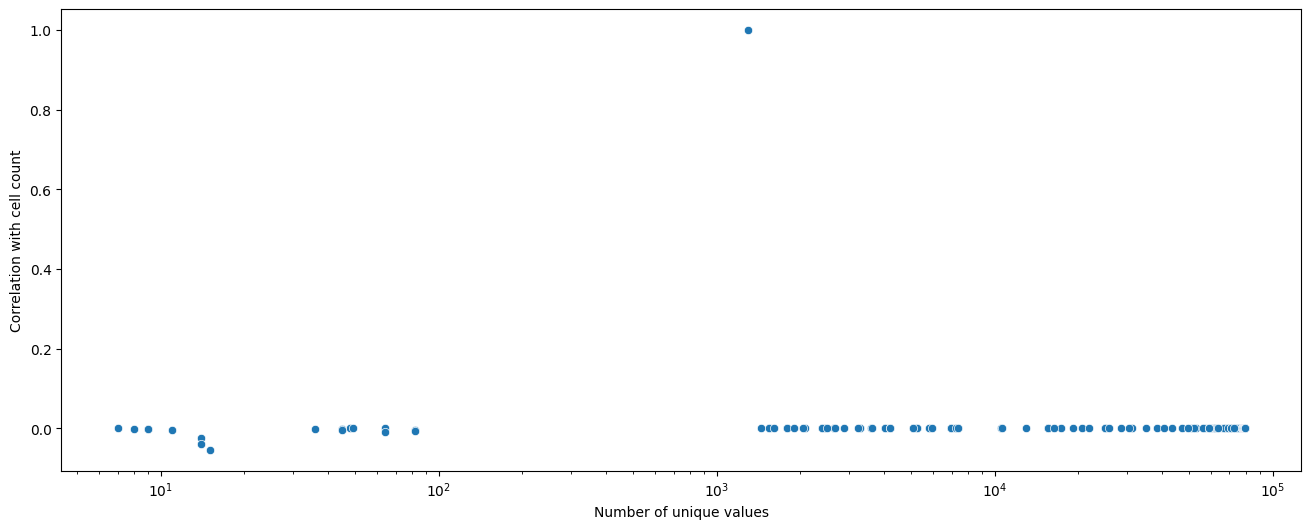

In [11]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    # hue=ann_profiles.filter(regex="^(?!Metadata_)")
    # .corrwith(ann_profiles["Cells_Count"])
    # .abs()
    # > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")


# plt.axhline(y=corr_cutoff, color="red", linestyle="--")
# plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Plot the ratio of unique values / size for cell count

This is one criteria to filter features in `feature_select`

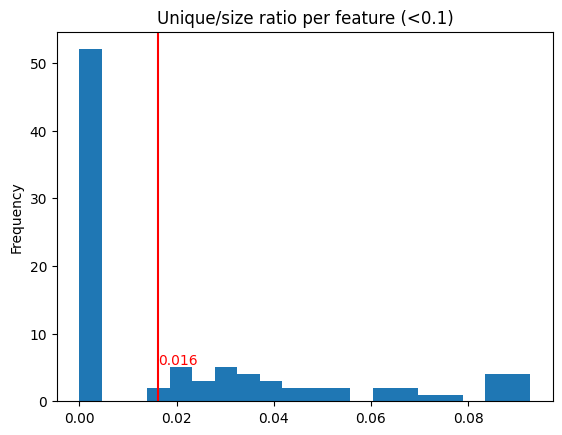

In [12]:
plot_unique_value_hist(ann_profiles, unique_ratio_cutoff = 0.1, features="Cells_Count")

#### Preprocess and save CC-corrected subset

In [13]:
ann_profiles = pd.read_parquet("output/profiles_cc_adjusted.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [14]:
ann_profiles = preprocess_profiles(ann_profiles, **preprocess_config)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_02_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_Mito_10_01_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Cells_Count
0,JCP2022_900257,ccsbBroad304_00280,ORF012864.1_TRC304.1,pLX_304,NM_001799.4,CDK7,1022,9606,cyclin dependent kinase 7,100.0,...,-1.231577,0.490227,0.062325,-0.435590,-0.229694,0.956789,0.753260,-0.012308,-1.296834,-1.152255
1,JCP2022_900258,ccsbBroad304_00281,ORF011987.1_TRC304.1,pLX_304,NM_001260.3,CDK8,1024,9606,cyclin dependent kinase 8,100.0,...,0.599487,-1.057567,-0.063772,0.000000,1.084028,-0.504171,-0.196982,-0.133785,0.537612,0.337245
2,JCP2022_900264,ccsbBroad304_00287,ORF008900.1_TRC304.1,pLX_304,NM_005193.1,CDX4,1046,9606,caudal type homeobox 4,100.0,...,0.482858,-0.077675,-0.832644,-0.890830,0.306157,-0.358296,-0.126532,-0.214288,-0.542846,-1.117125
3,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,...,0.828163,0.625896,-0.791639,-1.447235,-1.562389,-2.281529,2.627650,1.587568,0.823890,0.491816
4,JCP2022_900267,ccsbBroad304_00290,ORF016845.1_TRC304.1,pLX_304,NM_001252296.1,CEBPG,1054,9606,CCAAT enhancer binding protein gamma,100.0,...,-0.638493,-1.836099,1.026594,-0.993191,1.358627,0.130276,1.438015,0.316011,0.737111,0.126467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,1.136267,-1.204782,0.799465,-1.085394,0.890625,-1.481684,0.513214,1.077589,0.860113,-0.302011
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.081024,0.803678,1.048156,0.501873,-0.128035,-0.514228,0.016527,0.901899,-0.210535,-0.010067
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.337464,1.370658,-0.986768,-1.054934,-2.268375,0.697122,1.503346,-0.320936,-0.408083,-4.671100
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.556129,1.202156,-0.765855,0.031868,-0.676932,-0.072616,0.189121,1.006288,-1.585261,0.221475


In [15]:
# check that the cell count column is still there
assert cc_config["cc_col"] in ann_profiles.columns

ann_profiles.to_parquet("output/profiles_cc_adjusted_preprocessed.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_02_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_Mito_10_01_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Cells_Count
0,JCP2022_900257,ccsbBroad304_00280,ORF012864.1_TRC304.1,pLX_304,NM_001799.4,CDK7,1022,9606,cyclin dependent kinase 7,100.0,...,-1.231577,0.490227,0.062325,-0.435590,-0.229694,0.956789,0.753260,-0.012308,-1.296834,-1.152255
1,JCP2022_900258,ccsbBroad304_00281,ORF011987.1_TRC304.1,pLX_304,NM_001260.3,CDK8,1024,9606,cyclin dependent kinase 8,100.0,...,0.599487,-1.057567,-0.063772,0.000000,1.084028,-0.504171,-0.196982,-0.133785,0.537612,0.337245
2,JCP2022_900264,ccsbBroad304_00287,ORF008900.1_TRC304.1,pLX_304,NM_005193.1,CDX4,1046,9606,caudal type homeobox 4,100.0,...,0.482858,-0.077675,-0.832644,-0.890830,0.306157,-0.358296,-0.126532,-0.214288,-0.542846,-1.117125
3,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,...,0.828163,0.625896,-0.791639,-1.447235,-1.562389,-2.281529,2.627650,1.587568,0.823890,0.491816
4,JCP2022_900267,ccsbBroad304_00290,ORF016845.1_TRC304.1,pLX_304,NM_001252296.1,CEBPG,1054,9606,CCAAT enhancer binding protein gamma,100.0,...,-0.638493,-1.836099,1.026594,-0.993191,1.358627,0.130276,1.438015,0.316011,0.737111,0.126467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,1.136267,-1.204782,0.799465,-1.085394,0.890625,-1.481684,0.513214,1.077589,0.860113,-0.302011
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.081024,0.803678,1.048156,0.501873,-0.128035,-0.514228,0.016527,0.901899,-0.210535,-0.010067
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.337464,1.370658,-0.986768,-1.054934,-2.268375,0.697122,1.503346,-0.320936,-0.408083,-4.671100
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.556129,1.202156,-0.765855,0.031868,-0.676932,-0.072616,0.189121,1.006288,-1.585261,0.221475


#### Subtract well mean in cc adjusted profiles

In [16]:
ann_profiles = pd.read_parquet("output/profiles_cc_adjusted.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [17]:
ann_profiles = subtract_well_mean(ann_profiles)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,18.094840,15.845488,15.896356,15.462843,15.557788,16.101178,16.327914,15.581127,16.141176,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,18.625084,17.249607,17.746422,17.180869,17.575946,17.811782,18.718973,17.821226,18.522294,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,29.496356,27.860144,28.085855,27.528428,27.988382,28.374475,29.023083,27.946044,29.048460,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,3.504982,3.955709,4.166485,3.911565,4.177823,4.240609,4.642764,4.321645,4.667072,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,35.112576,33.874398,33.433527,33.197952,33.690558,34.108267,34.717148,33.564914,34.645391,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,10.534510,9.274802,9.232546,9.150787,8.995247,9.125396,9.274980,9.040851,9.111568,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,18.715211,17.831739,17.909115,18.154830,18.078674,17.963920,18.365409,18.113016,18.411996,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,12.357783,11.619484,11.388913,11.841221,11.629627,11.180517,11.088060,11.696845,11.538679,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,10.560400,10.124359,10.121988,10.167606,10.320124,10.230216,10.487286,10.242439,10.538297,2021_08_30_Batch13


In [18]:
ann_profiles.to_parquet("output/full_profiles_cc_adj_mean_corr.parquet", index=False)

In [19]:
ann_profiles = preprocess_profiles(ann_profiles, **preprocess_config)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas2_DNA_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InfoMeas2_RNA_3_00_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_03_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_Mito_10_03_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Nuclei_Texture_SumVariance_ER_10_01_256,Cells_Count
0,JCP2022_900257,ccsbBroad304_00280,ORF012864.1_TRC304.1,pLX_304,NM_001799.4,CDK7,1022,9606,cyclin dependent kinase 7,100.0,...,-0.086402,0.456224,0.700245,0.291046,-0.087758,0.506805,-0.308410,-1.256192,-0.997793,-0.619292
1,JCP2022_900258,ccsbBroad304_00281,ORF011987.1_TRC304.1,pLX_304,NM_001260.3,CDK8,1024,9606,cyclin dependent kinase 8,100.0,...,0.414273,0.555641,-0.655235,0.135209,-0.884628,-0.932580,-0.106488,0.490328,1.602166,0.936958
2,JCP2022_900264,ccsbBroad304_00287,ORF008900.1_TRC304.1,pLX_304,NM_005193.1,CDX4,1046,9606,caudal type homeobox 4,100.0,...,-0.779032,-0.386513,-0.557848,-0.326870,-0.160549,-0.411857,0.160352,-0.934831,-0.491796,-0.791061
3,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,...,-2.781218,-3.963993,-2.110178,-4.537758,1.688389,2.886424,1.474742,0.004469,-1.425807,-0.549618
4,JCP2022_900267,ccsbBroad304_00290,ORF016845.1_TRC304.1,pLX_304,NM_001252296.1,CEBPG,1054,9606,CCAAT enhancer binding protein gamma,100.0,...,-0.033917,-0.153706,-0.145185,-0.185935,0.756143,0.354097,0.697646,-0.666773,0.235939,0.023087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-0.789700,-0.359817,-0.780219,0.331250,0.147457,0.273237,1.005861,-0.434207,-0.867785,-0.974995
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.448500,0.865137,-0.757088,-0.585278,-0.640179,0.128282,0.765005,0.246946,-0.202649,0.693374
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.815270,-1.841199,0.309665,-2.522745,0.923912,1.412692,-0.042578,-0.073430,0.026199,-2.548669
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.421878,0.165000,-0.360294,-1.698831,0.714182,-0.214438,1.207206,-0.927648,-0.356581,1.121790


In [20]:
ann_profiles.to_parquet(
    "output/full_profiles_cc_adj_mean_corr_preprocessed.parquet", index=False
)